<center><h3>Deep learning forecasting on Bitcoin</h3></center>

The goal of this notebook is to try to forecast the Bitcoin price for the next months.

It is not an easy matter so we will go step by step, time series are no joke ! :)

<h3>Part 1: LSTM prediction</h3>

In [15]:
import pandas as pd
import numpy as np

input_df = pd.read_csv(r'market-price2.csv')
input_df.Date = pd.to_datetime(input_df.Date)
input_df = input_df.set_index('Date')
input_df = input_df.fillna(method='backfill')
print('Number of NaN values:\n' + str(input_df.isnull().sum()))
input_df.tail(10)

Number of NaN values:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-10-05,49174.960938,51839.984375,49072.839844,51514.812500,51514.812500,3.587390e+10
2021-10-06,51486.664063,55568.464844,50488.191406,55361.449219,55361.449219,4.903473e+10
2021-10-07,55338.625000,55338.625000,53525.468750,53805.984375,53805.984375,3.680786e+10
2021-10-08,53802.144531,55922.980469,53688.054688,53967.847656,53967.847656,3.480087e+10
2021-10-09,53929.781250,55397.945313,53735.144531,54968.222656,54968.222656,3.249121e+10
2021-10-10,54952.820313,56401.304688,54264.257813,54771.578125,54771.578125,3.952779e+10
2021-10-11,54734.125000,57793.039063,54519.765625,57484.789063,57484.789063,4.263733e+10
2021-10-12,57526.832031,57627.878906,54477.972656,56041.058594,56041.058594,4.108376e+10
2021-10-13,56038.257813,57688.660156,54370.972656,57401.097656,57401.097656,4.168425e+10


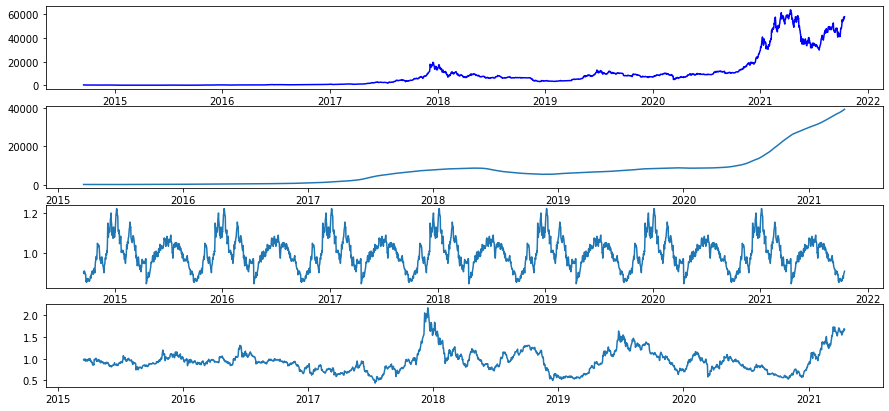

In [46]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
result = seasonal_decompose(input_df['Close'], model='multiplicative', period = 365)

plt.figure(figsize=(15, 7))
plt.subplot(4,1,1)
plt.plot(input_df['Close'], color='blue', label='Trend')

plt.subplot(4,1,2)
plt.plot(result.trend)

plt.subplot(4,1,3)
plt.plot(result.seasonal)

plt.subplot(4,1,4)
plt.plot(result.resid)

We can observe that the trend is constantly rising and the seasonality is clearly defined with peaks toward January and June.

But there are also noises toward December 2018 and 2021, which mean there are other factors that influenced theses periods.

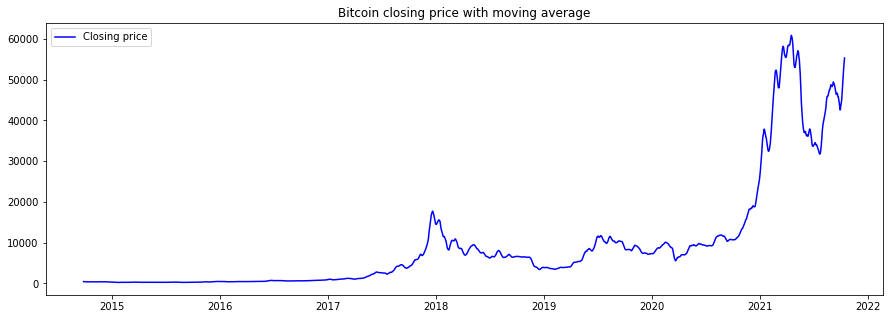

In [3]:
window_size = 10
input_df = input_df.rolling(window=window_size, center=False).mean()
#Moving Average based on the last 10 days

plt.figure(figsize=(15, 5))
plt.plot(input_df['Close'], color='b', label='Closing price')
#plt.plot(input_df['Close_MA'], color='b', label='Moving average')
plt.title('Bitcoin closing price with moving average')
plt.legend()

The moving average is useful when making predictions because it lower the noise of the data, thus making it more reliable.

We will only be using the closing price to begin with.

In [4]:
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator

n_futur = 120 # Number of days we want to predict into the future.
n_past = 240 # Number of past days we want to use to predict future.

sc = StandardScaler()

df_train= input_df[['Close']][window_size:-n_futur].values
print(df_train.shape)
print(df_train[-1][0])
df_test= input_df[['Close']][-n_futur:].values
print(df_test.shape)

date_train = input_df[:-n_futur].index
date_test = input_df[-n_futur:].index

sc.fit_transform(df_train)
df_train = sc.transform(df_train)

BATCH_SIZE = 32
train_generator = TimeseriesGenerator(df_train, df_train,  length=n_past, batch_size=BATCH_SIZE)

(2455, 1)
37203.7640626
(120, 1)


In [5]:
import tensorflow as tf
from keras import models
from keras import layers

regressor = models.Sequential([
    #layers.Conv1D(filters=32, kernel_size=3, strides=1, padding="causal", activation="relu", input_shape=[None, 6]),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True), input_shape=[None, 1]),
    layers.Dropout(0.1),
    layers.Bidirectional(layers.LSTM(128, return_sequences=False)),
    layers.Dropout(0.1),
    layers.Dense(20)])

regressor.summary()

regressor.compile(loss='mean_squared_error', optimizer='adam')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, None, 256)         133120    
_________________________________________________________________
dropout (Dropout)            (None, None, 256)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                5140      
Total params: 532,500
Trainable params: 532,500
Non-trainable params: 0
_________________________________________________________________


In [6]:
regressor.fit(train_generator, epochs = 10)

regressor.save_weights('LSTM_weigth.h5')

Epoch 1/10
70/70 [==============================] - 13s 95ms/step - loss: 0.2585 0s - loss: 0.26
Epoch 2/10
70/70 [==============================] - 7s 95ms/step - loss: 0.1072: 0s - l
Epoch 3/10
70/70 [==============================] - 7s 96ms/step - loss: 0.0564: 4s - loss: 0.03 - - ET
Epoch 4/10
70/70 [==============================] - 7s 96ms/step - loss: 0.0937
Epoch 5/10
70/70 [==============================] - 7s 96ms/step - loss: 0.0378
Epoch 6/10
70/70 [==============================] - 7s 96ms/step - loss: 0.0714: 0s - los
Epoch 7/10
70/70 [==============================] - 7s 97ms/step - loss: 0.0514: 1s - 
Epoch 8/10
70/70 [==============================] - 7s 97ms/step - loss: 0.0913: 1s 
Epoch 9/10
70/70 [==============================] - 7s 96ms/step - loss: 0.0710: 4s - l - ETA: 3 - ET
Epoch 10/10
70/70 [==============================] - 7s 96ms/step - loss: 0.0260


In [7]:
regressor.load_weights('LSTM_weigth.h5')

In [8]:
def predict(num_prediction, model):
    prediction_list = df_train[-n_past:]
    
    for _ in range(num_prediction):
        x = prediction_list[-n_past:]
        x = x.reshape(1, n_past, 1)
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[n_past-1:]
        
    return prediction_list

def predict_dates(num_prediction):
    prediction_dates = pd.date_range(date_train[-1], periods=num_prediction+1, freq='1D').tolist()
    return prediction_dates

forecast = predict(n_futur, regressor).reshape(-1, 1)
print(forecast.shape)
forecast = sc.inverse_transform(forecast)
date_forecast = predict_dates(n_futur)
print(forecast.shape)

(121, 1)
(121, 1)


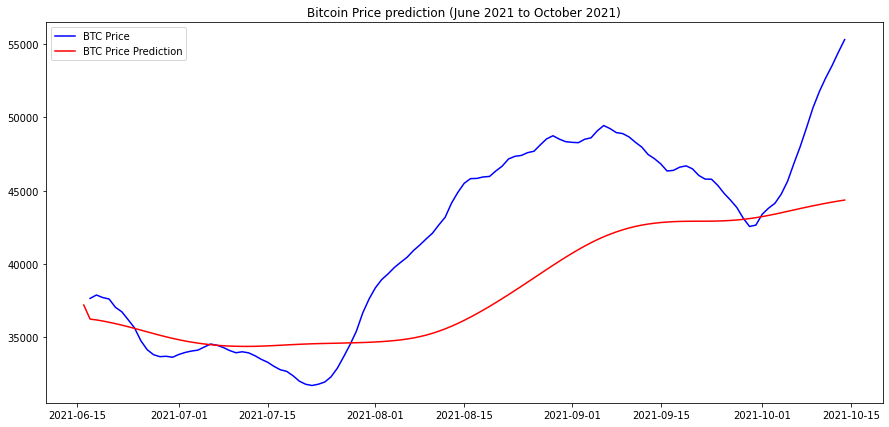

In [9]:
plt.figure(figsize=(15, 7))
plt.plot(date_test, df_test, color='b', label='BTC Price')
plt.plot(date_forecast, forecast, color='red', label='BTC Price Prediction')
plt.title('Bitcoin Price prediction (June 2021 to October 2021)')
plt.legend()

Each subdivisions correspond to one day, here we have 6 months of prediction.

The model did understand the rising tendency but won't be really accurate.

Next we will train the model to predict the futur beyond the dataset.

In [10]:
df_train= input_df[['Close']][window_size:].values
date_train = input_df[['Close']][window_size:].index

sc.fit(df_train)
df_train = sc.transform(df_train)

train_generator = TimeseriesGenerator(df_train, df_train,  length=n_past, batch_size=BATCH_SIZE)

In [11]:
regressor.fit(train_generator, epochs = 10)

Epoch 1/10
73/73 [==============================] - 7s 99ms/step - loss: 0.0167: 6s - loss: - ETA: 0s - loss: 
Epoch 2/10
73/73 [==============================] - 7s 99ms/step - loss: 0.0184
Epoch 3/10
73/73 [==============================] - 7s 99ms/step - loss: 0.0191:
Epoch 4/10
73/73 [==============================] - 7s 98ms/step - loss: 0.0123
Epoch 5/10
73/73 [==============================] - 7s 97ms/step - loss: 0.0105
Epoch 6/10
73/73 [==============================] - 7s 97ms/step - loss: 0.0093
Epoch 7/10
73/73 [==============================] - 7s 98ms/step - loss: 0.0127: 0s - lo
Epoch 8/10
73/73 [==============================] - 7s 98ms/step - loss: 0.0095
Epoch 9/10
73/73 [==============================] - 7s 97ms/step - loss: 0.0070
Epoch 10/10
73/73 [==============================] - 7s 98ms/step - loss: 0.0083: 0s - loss: 


In [12]:
forecast = predict(n_futur, regressor).reshape(-1, 1)
forecast = sc.inverse_transform(forecast)
date_forecast = predict_dates(n_futur)
df_train = sc.inverse_transform(df_train)
print(forecast.shape)

(121, 1)


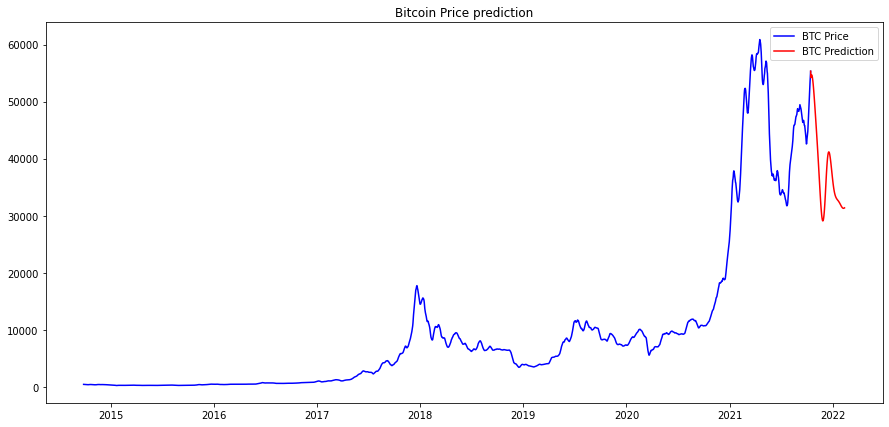

In [13]:
plt.figure(figsize=(15, 7))
plt.plot(date_train, df_train, color='blue', label='BTC Price')
plt.plot(date_forecast, forecast, color='red', label='BTC Prediction')
plt.title('Bitcoin Price prediction')
plt.legend()

I don't think this is a good prediction... But we'll see !

Time series tends to overfit very easily.

Thank you for watching my messy attempt at predicting anything from a time serie.